## Carga de librerías

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re
import numpy as np
from collections import Counter
import keras
from keras import layers
from keras import ops
from livelossplot import PlotLossesKerasTF

## Carga de datos

https://www.kaggle.com/competitions/spooky-author-identification/data

In [3]:
data = pd.read_csv("spooky-author-identification/train.zip")

In [ ]:
# data.text
# data.text.to_csv("corpus.txt", index=False, header=False)

In [3]:
data["text"].map(len).describe()

count    19579.000000
mean       149.057408
std        106.800189
min         21.000000
25%         81.000000
50%        128.000000
75%        191.000000
max       4663.000000
Name: text, dtype: float64

In [4]:
X = data.text.values
y = data.author.values

## Preprocesamiento

### Tokenización
Cómo queremos distinguir el estilo de 3 autores, vamos a dejar los signos de puntuación, ya que su uso puede ser un elemento caracterísco de cada autor. Del mismo modo, no aplicaremos más procesamiento a las tokens, porque el usar unas formas u otras podría ser un rasgo del estilo de un autor. Cabría la posibilidad de hacerlo. 

In [ ]:
def tokenize(X):
    return [re.findall(r'\w+|[^\w\s]', sentence) for sentence in X]
    # return re.findall(r'\w+|[^\w\s]', sentence)


def enconder_word2int(X, vocab, word_counter = None, vocab_size=None):

    if not vocab_size:
        vocab_size = len(vocab)

    limited_vocab = [k for k, _ in word_counter.most_common(vocab_size-1)]
    word_encoder = {w:i+1 for i,w in enumerate(limited_vocab)}
    
    return np.array([list([word_encoder.get(w,0) for w in s]) for s in X], dtype=object)

def pipe(value, *funcs):
    for func in funcs:
        value = func(value)
    return value

layer.Embedding toma numeros del 1 al vocab_size -> Hay que codificar los tokens

In [6]:
vocab = {token  for sentence in tokenize(X) for token in sentence}
print(f"Nuestro vocabulario tiene {len(vocab)} tokens")

Nuestro vocabulario tiene 27503 tokens


In [7]:
vocab_size=20000

word_counter = Counter()
for tokens in tokenize(X):
    word_counter.update(tokens)

In [8]:
tokens_mas_frecuentes = sorted(word_counter.items(), key=lambda x: x[1], reverse=True)[:20]

print("20 tokens más frecuentes en el dataset:")
print("-" * 40)
print(f"{'Palabra':<20} | {'Frecuencia':<10}")
print("-" * 40)
for token, frecuencia in tokens_mas_frecuentes:
    print(f"{token:<20} | {frecuencia:<10}")

20 tokens más frecuentes en el dataset:
----------------------------------------
Palabra              | Frecuencia
----------------------------------------
,                    | 38220     
the                  | 33344     
of                   | 20873     
.                    | 20075     
and                  | 17427     
to                   | 12652     
I                    | 10806     
a                    | 10383     
in                   | 8843      
was                  | 6615      
that                 | 6259      
;                    | 5159      
my                   | 5045      
"                    | 4969      
had                  | 4382      
with                 | 4220      
it                   | 3961      
his                  | 3824      
as                   | 3546      
he                   | 3533      


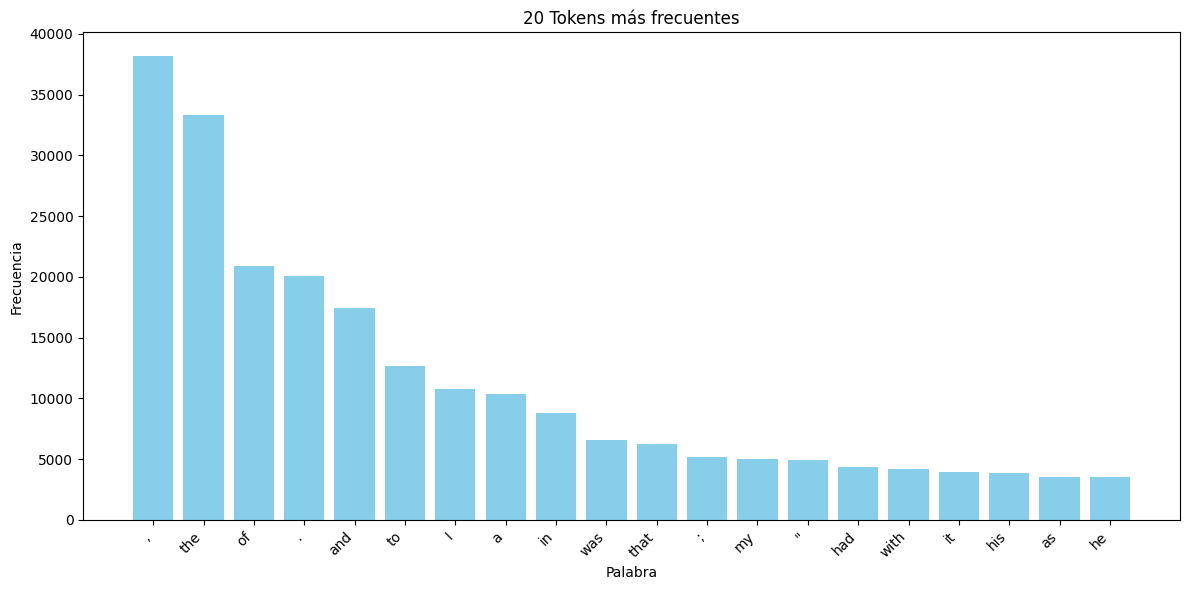

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
tokens = [item[0] for item in tokens_mas_frecuentes]
frecuencias = [item[1] for item in tokens_mas_frecuentes]

plt.bar(tokens, frecuencias, color='skyblue')
plt.title('20 Tokens más frecuentes')
plt.xlabel('Palabra')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Pipeline de preprocesamiento

In [10]:
vocab_size=20000
maxlen = 80

X = pipe(data.text,
         tokenize,
         lambda x: enconder_word2int(x, vocab, word_counter, vocab_size),
         lambda x: keras.utils.pad_sequences(x, maxlen=maxlen) 
)
X

array([[    0,     0,     0, ...,     2,   458,     4],
       [    0,     0,     0, ...,   450,  2412,     4],
       [    0,     0,     0, ...,   510,  2757,     4],
       ...,
       [    0,     0,     0, ..., 16528, 16118,     4],
       [    0,     0,     0, ...,   561,     4,    14],
       [    0,     0,     0, ...,     3,  6155,     4]])

In [11]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)
y

array([0, 1, 0, ..., 0, 0, 1])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(len(X_train), "Training sequences")
print(len(X_test), "Validation sequences")

14684 Training sequences
4895 Validation sequences


Transformer

In [13]:
# vocab_size = 20000  # Only consider the top 20k words, las palabras menos frecuentes pueden ser más difíciles de clasificar. Esto hace que sea más eficiente
# maxlen = 80  # Only consider the first 200 words of each movie review
# print(len(X_train), "Training sequences")
# print(len(X_test), "Validation sequences")
# X_train = keras.utils.pad_sequences(X_train, maxlen=maxlen) # Las que tengan más maxlen palabras las cortas y las que tengan menos, las completas con 0
# X_test = keras.utils.pad_sequences(X_test, maxlen=maxlen)

vocab_size hay que meterlo!!

In [14]:
# layers.Embedding toma enteros dentro del rango [0, vocab_size) ----> Hay que hacer el enconding después de quedarse con los más frecuentes

In [15]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        """
        embed_dim: dimensión de embedings
        num_heads: número de cabezas
        ff_dim: número de neuronas de la capa densa
        rate: dropout rate
        """

        super().__init__() # Hace la llamada al constructor de la clase padre para que todo lo que hiciese este, lo haga el nuestro también
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), 
             layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6) # epsilon es un término que se suma a la varianza para evitar divisiones por 0
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs) # Porque el att está pensado para hacer atención cruzada (toma de uno los q's y de la otra las k's y las v's). 
        attn_output = self.dropout1(attn_output)                                                          # Si pongo los dos iguales, hago atención "normal"
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)
    # No trabajamos con unos embeddings preentrenados, si no que empezamos con embeddings aleatorios y se van aprendiendo durante el entrenamiento

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        """
        maxlen: longitud máxima de la entrada (si es menor rellena con <eos>)
        vocab_size: tamaño del vocabulario
        embed_dim: dimensión del embedding
        """
        super().__init__() # Hereda de Layer de keras, por lo que tendrá todo lo que tenga esa clase más lo que le añadamos ahora
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim) # entra un vector one-hot del vocabulario
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim) # entra un vector de tamaño de la longitud máxima, 
                                                                                # con un 1 indicando la posición de la palabra y 0 lo demás

    def call(self, x):
        """
        x: matriz en la que tenemos una fila por cada review y cada columna representa cada una de las palabras de la review (con números, i.e. 1 es la 1º palabra del vocab,...)
        """
        maxlen = ops.shape(x)[-1]
        positions = ops.arange(start=0, stop=maxlen, step=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [21]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
rate = 0.5

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
x = TransformerBlock(embed_dim, num_heads, ff_dim)(x) # De aquí sale Z: una matriz donde cada fila es el vector de cada token enriquecido
x = layers.GlobalAveragePooling1D()(x) # Usamo GAP para reducir la dimensionalidad (Hace la media por filas). Otra opción: layers.flatten(), problema: aumenta mucho la dimensión
x = layers.Dropout(rate)(x)
x = layers.Dense(40, activation="relu")(x)
x = layers.Dropout(rate)(x)
outputs = layers.Dense(3, activation="softmax")(x) # Tendremos la probabilidad de cada una de las clases

model = keras.Model(inputs=inputs, outputs=outputs)

In [23]:
model.compile(
    optimizer= keras.optimizers.Adam(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Definir el callback de Early Stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',    # Monitoriza la pérdida en la validación
    patience=5,            # Número de épocas sin mejora antes de detener el entrenamiento
    restore_best_weights=True # Restaura los mejores pesos al finalizar
)

history = model.fit(
    X_train, 
    y_train, 
    batch_size=32, 
    epochs=20, 
    validation_data=(X_test, y_test), 
    callbacks=[PlotLossesKerasTF(),
               early_stopping]
)

Epoch 1/20
402/459 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9134 - loss: 0.2549

KeyboardInterrupt: 

## Evaluación

In [19]:
pred_probs = model.predict(X_test)
pred_class = ops.argmax(pred_probs,axis=1)
acc_test = ops.mean(pred_class == y_test)
print("Accuracy en test: ", acc_test.numpy())

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy en test:  0.84044945


In [28]:
from sklearn.metrics import log_loss, confusion_matrix, ConfusionMatrixDisplay

log_loss(y_test,pred_probs)

0.41688263911536366

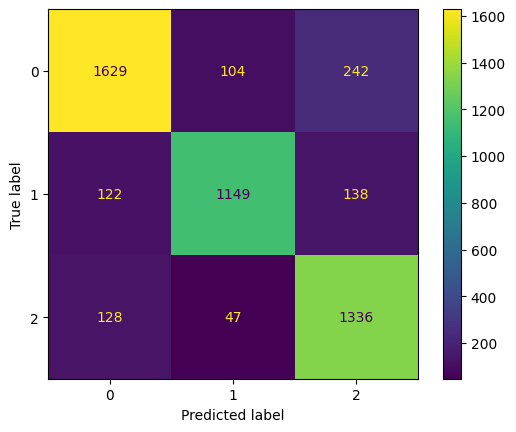

In [33]:
cm = confusion_matrix(y_test,pred_class)

disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()